# Setup

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the model

## General Case

In [29]:
tau = 0.2

In [30]:
def g0_sampler():
    return np.random.normal(0, 1)

def f_sampler(theta):
    return np.random.normal(theta, tau)

def F_likelihood(theta, x):
    return np.exp(-(theta - x)**2 / (2 * tau**2))

## Conjugate prior case

In [51]:
def Hi_sampler(y):
    m = (y / tau**2) / (1 / tau**2 + 1 / 1**2)
    s = 1 / (1 / tau**2 + 1 / 1**2)
    return np.random.normal(m, s)

def ri_integral(y):
    return tau * np.exp(-y**2 / (2 + 2 * tau**2)) / np.sqrt(tau**2 + 1)

# Generate Data

In [32]:
def DP_sampler(n, alpha):
    # Sample the thetas
    thetas = []
    for i in range(n):
        u = np.random.uniform()
        if u < alpha / (alpha + i):
            thetas.append(g0_sampler())
        else:
            thetas.append(thetas[np.random.randint(0, i)])
    return thetas

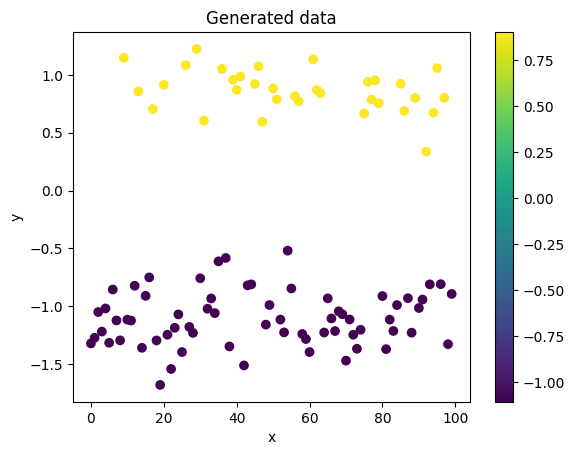

In [45]:
# Generate data
n = 100
alpha = 0.25
thetas = DP_sampler(n, alpha)
y = np.array([f_sampler(theta) for theta in thetas])

# Plot data
plt.figure()
plt.scatter(np.arange(n), y, c=thetas)
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

# Util Functions

In [46]:
def find_unused_cluster(c):
    # Find the first unused cluster
    for k in range(len(c)):
        if np.sum(c == k) == 0:
            return k

    raise Exception("No unused cluster found")

In [62]:
def update_cluster_phis(c, phi, y):
    for c_unique in np.unique(c):
        phi[c_unique] = np.mean(y[c == c_unique])
        # TODO: CHECK THIS

# Algorithms

## Algorithm 1

In [63]:
def algorithm_1(N, y, alpha):
    # Initialize
    n = len(y)
    thetas = np.zeros((N+1, n), dtype=float)
    lhs = np.zeros((N+1, n), dtype=float)

    # Loop over data
    for i in range(1, N+1):
        theta = thetas[i-1].copy()
        lh = lhs[i-1].copy()

        # Perform Gibbs sampling
        for j in range(n):
            lh_proposals = np.zeros(n, dtype=float)
            for theta_unique in np.unique(theta):
                lh_proposals[theta == theta_unique] = F_likelihood(theta_unique, y[j])
            lh_proposals[j] = alpha * ri_integral(y[j])

            # Sample j
            j_proposal = np.random.choice(n, p=lh_proposals / np.sum(lh_proposals))
            if j_proposal == j:
                theta[j] = Hi_sampler(y[j])
                lh[j] = F_likelihood(theta[j], y[j])
            else:
                theta[j] = theta[j_proposal]
                lh[j] = lh_proposals[j_proposal]

        thetas[i] = theta
        lhs[i] = lh

    return thetas, lhs

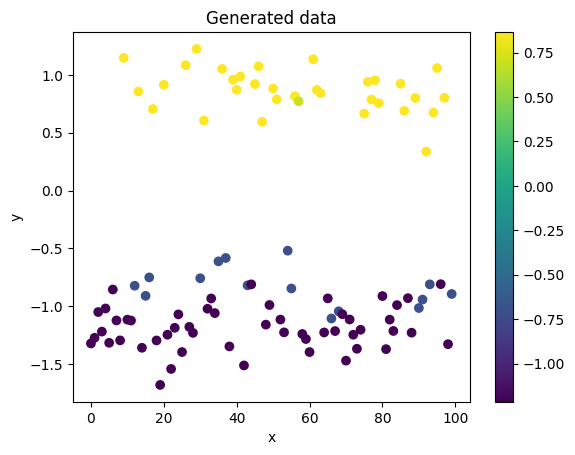

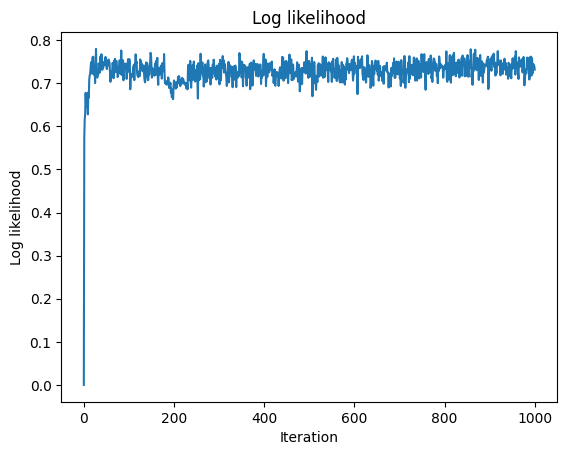

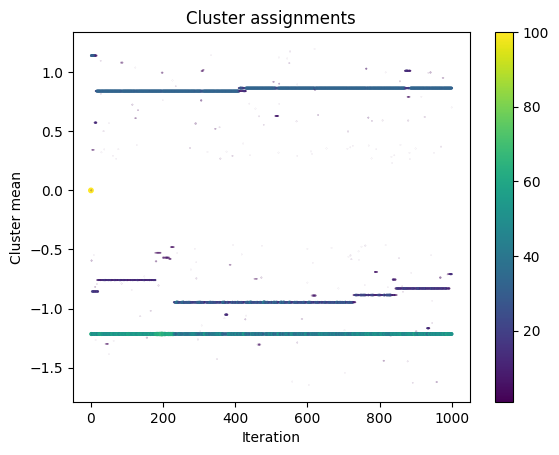

In [64]:
# Run algorithm
N = 1000
thetas, lhs = algorithm_1(N, y, alpha)

# Plot results
plt.figure()
plt.scatter(np.arange(n), y, c=thetas[N])
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

plt.figure()
plt.plot(np.arange(N+1), np.mean(lhs, axis=1))
plt.title("Log likelihood")
plt.xlabel("Iteration")
plt.ylabel("Log likelihood")
plt.show()

# plot evolution of theta
plt.figure()
it_list = []
phi_list = []
size_list = []
for it in range(0, N+1):
    phis_counts = np.unique(thetas[it], return_counts=True)
    phi_list.extend(phis_counts[0])
    it_list.extend([it] * len(phis_counts[0]))
    size_list.extend(phis_counts[1])

plt.scatter(it_list, phi_list, s= 10 * np.square(np.array(size_list, dtype=float) / np.max(size_list)), c=size_list)
plt.title("Cluster assignments")
plt.xlabel("Iteration")
plt.ylabel("Cluster mean")
plt.colorbar()
plt.show()


## Algorithm 4

In [59]:
def algorithm_4(N, y, alpha):
    n = len(y)
    cs = np.zeros((N+1, n), dtype=int)
    phis = np.zeros((N+1, n), dtype=float)

    for i in range(1, N+1):
        c = cs[i-1].copy()
        phi = phis[i-1].copy()

        for j in range(n):
            k = len(np.unique(c[np.arange(n) != j]))
            c_proposal = find_unused_cluster(c)
            phi_proposal = g0_sampler()

            if np.sum(c == c[j]) == 1:
                if np.random.uniform() < 1 / (k + 1):
                    c[j] = c_proposal
                    phi[c[j]] = phi_proposal
            
            else:
                lh_proposals = np.zeros(n)
                for c_unique in np.unique(c):
                    lh_proposals[c == c_unique] = F_likelihood(phi[c_unique], y[j])

                lh_proposals[j] = (alpha / (k + 1)) * F_likelihood(phi_proposal, y[j])

                j_proposal = np.random.choice(n, p=lh_proposals / np.sum(lh_proposals))

                if j_proposal == j:
                    c[j] = c_proposal
                    phi[c[j]] = phi_proposal
                else:
                    c[j] = c[j_proposal]
                    phi[c[j]] = phi[c[j_proposal]]

        update_cluster_phis(c, phi, y)
            
        cs[i] = c
        phis[i] = phi

    return cs, phis

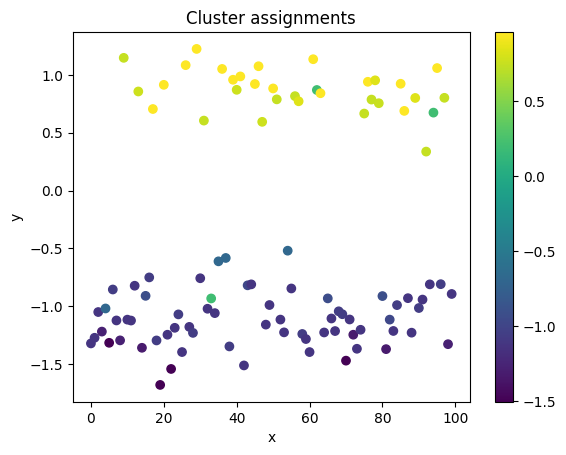

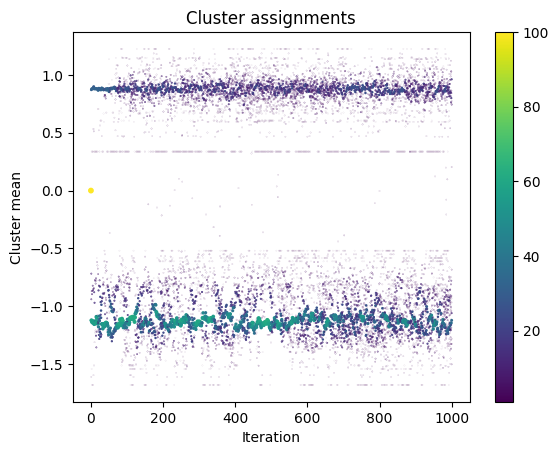

In [60]:
# Run algorithm
N = 1000
cs, phis = algorithm_4(N, y, alpha)

# Plot results
plt.figure()
plt.scatter(np.arange(n), y, c=phis[N, cs[N]])
plt.title("Cluster assignments")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

# plot evolution of theta
plt.figure()
it_list = []
phi_list = []
size_list = []
for it in range(0, N+1):
    phis_counts = np.unique(cs[it], return_counts=True)
    phi_list.extend(phis[it][phis_counts[0]])
    it_list.extend([it] * len(phis_counts[0]))
    size_list.extend(phis_counts[1])

plt.scatter(it_list, phi_list, s= 10 * np.square(np.array(size_list, dtype=float) / np.max(size_list)), c=size_list)
plt.title("Cluster assignments")
plt.xlabel("Iteration")
plt.ylabel("Cluster mean")
plt.colorbar()
plt.show()

## Algorithm 6

In [54]:
def algorithm_6_sample(theta, alpha):
    # Choose wether we sample from existing theta or from g0
    if np.random.rand() < alpha / (len(theta) + alpha):
        # Sample from g0
        theta = g0_sampler()
    else:
        # Sample from existing theta
        theta = np.random.choice(theta)

    return theta

def algorithm_6(N, y, alpha):
    n = len(y)
    thetas = np.zeros((N+1, n))
    lhs = np.zeros((N+1, n))
    lhs[0] = np.array([F_likelihood(thetas[0, j], y[j]) for j in range(n)])

    for i in range(1, N+1):
        theta = thetas[i-1].copy()
        lh = lhs[i-1].copy()
        for j in range(n):
            theta_proposal = algorithm_6_sample(theta[np.arange(n) != j], alpha)
            lh_proposal = F_likelihood(theta_proposal, y[j])

            # Compute acceptance probability
            a = min(1, lh_proposal / lh[j])

            # Accept or reject
            if np.random.rand() < a:
                theta[j] = theta_proposal
                lh[j] = lh_proposal
            
        thetas[i] = theta.copy()
        lhs[i] = lh.copy()

    return thetas, lhs


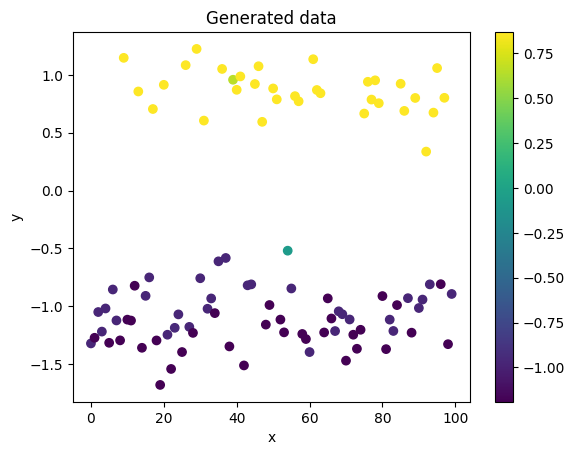

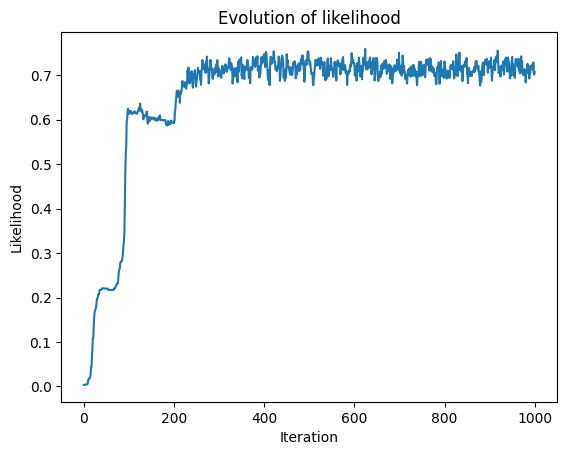

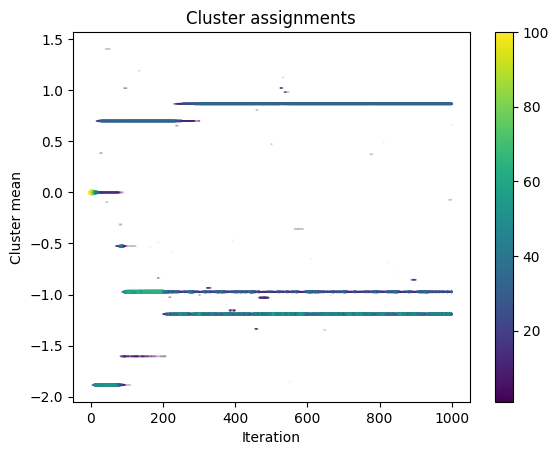

In [55]:
n = 100
N = 1000
alpha = 0.25

thetas, lhs = algorithm_6(N, y, alpha)
theta = thetas[-1]

# plot y coloured by theta
plt.figure()
plt.scatter(np.arange(n), y, c=theta)
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

# plot evolution of lh
plt.figure()
plt.plot(np.mean(lhs, axis=1))
plt.title("Evolution of likelihood")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.show()

# plot evolution of theta
plt.figure()
it_list = []
phi_list = []
size_list = []
for it in range(0, N+1):
    phis_counts = np.unique(thetas[it], return_counts=True)
    phi_list.extend(phis_counts[0])
    it_list.extend([it] * len(phis_counts[0]))
    size_list.extend(phis_counts[1])

plt.scatter(it_list, phi_list, s= 10 * np.square(np.array(size_list, dtype=float) / np.max(size_list)), c=size_list)
plt.title("Cluster assignments")
plt.xlabel("Iteration")
plt.ylabel("Cluster mean")
plt.colorbar()
plt.show()

## Algorithm 7

In [57]:
def algorithm_7(N, y, alpha):
    n = len(y)
    cs = np.zeros((N+1, n), dtype=int)
    phis = np.zeros((N+1, n), dtype=float)
    lhs = np.zeros((N+1, n), dtype=float)
    lhs[0] = np.array([F_likelihood(phis[0, j], y[j]) for j in range(len(y))])

    for i in range(1, N+1):
        c = cs[i-1].copy()
        phi = phis[i-1].copy()
        lh = lhs[i-1].copy()

        for j in range(n):
            # test if c[j] is a singleton
            if np.sum(c == c[j]) == 1:
                # Choose c[j] from c[-j] with probability n_i / (n - 1)
                c_proposal = np.random.choice(c[c != c[j]])
                lh_proposal = F_likelihood(phi[c_proposal], y[j])

                # Compute acceptance probability
                a = min(1, ((n-1) / alpha) * lh_proposal / lh[j])

                # Accept or reject
                if np.random.rand() < a:
                    c[j] = c_proposal
                    phi[c[j]] = phi[c_proposal]
                    lh[j] = lh_proposal

            else:
                c_proposal = find_unused_cluster(c)
                phi_proposal = g0_sampler()
                lh_proposal = F_likelihood(phi_proposal, y[j])

                # Compute acceptance probability
                a = min(1, (alpha / (n - 1)) * lh_proposal / lh[j])

                # Accept or reject
                if np.random.rand() < a:
                    c[j] = c_proposal
                    phi[c[j]] = phi_proposal
                    lh[j] = lh_proposal

        for j in range(n):
            # test if c[j] is not a singleton
            if np.sum(c == c[j]) > 1:

                # Compute transition probas
                lh_proposals = np.zeros(len(c))
                for c_unique in np.unique(c):
                    lh_proposals[c == c_unique] = F_likelihood(phi[c_unique], y[j])
                lh_proposals[j] = 0

                c[j] = np.random.choice(c, p=lh_proposals / np.sum(lh_proposals))
                lh[j] = lh_proposals[c[j]]

        update_cluster_phis(c, phi, y)

        cs[i] = c.copy()
        phis[i] = phi.copy()
        lhs[i] = lh.copy()

    return cs, phis, lhs

C:\Users\Marius\AppData\Local\Temp\ipykernel_11948\4150824154.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  a = min(1, (alpha / (n - 1)) * lh_proposal / lh[j])
C:\Users\Marius\AppData\Local\Temp\ipykernel_11948\4150824154.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  a = min(1, ((n-1) / alpha) * lh_proposal / lh[j])


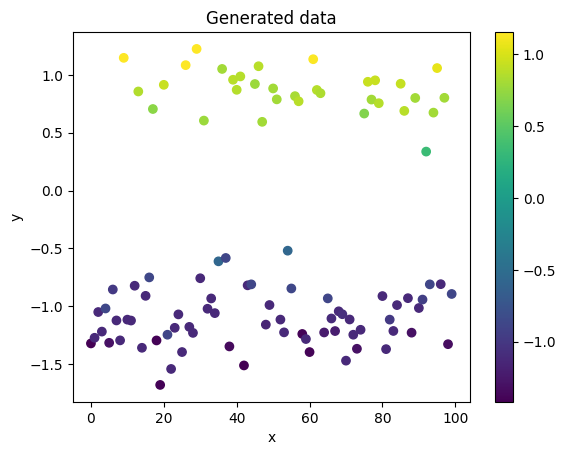

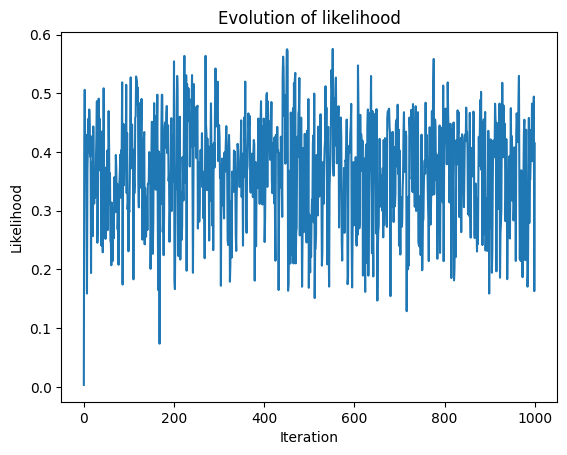

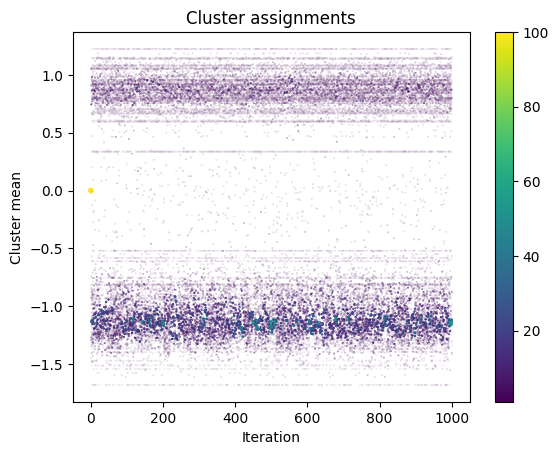

In [58]:
# Run algorithm 7
n = 100
N = 1000
alpha = 0.25

cs, phis, lhs = algorithm_7(N, y, alpha)
c = cs[-1]
phi = phis[-1]

# plot y coloured by theta
plt.figure()
plt.scatter(np.arange(n), y, c=phi[c])
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

# plot evolution of lh
plt.figure()
plt.plot(np.mean(lhs, axis=1))
plt.title("Evolution of likelihood")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.show()

# plot evolution of theta
plt.figure()
it_list = []
phi_list = []
size_list = []
for it in range(0, N+1):
    phis_counts = np.unique(cs[it], return_counts=True)
    phi_list.extend(phis[it][phis_counts[0]])
    it_list.extend([it] * len(phis_counts[0]))
    size_list.extend(phis_counts[1])

plt.scatter(it_list, phi_list, s= 10 * np.square(np.array(size_list, dtype=float) / np.max(size_list)), c=size_list)
plt.title("Cluster assignments")
plt.xlabel("Iteration")
plt.ylabel("Cluster mean")
plt.colorbar()
plt.show()